Use an implementation of Hamiltonian MC (`NUTS`) to infer properties of macro lens and one massive subhalo.

In [1]:
import sys, os
sys.path.append('../')

# Use Theano version of lensing gradient
os.environ["DIFF"] = "0"

import numpy as np
import matplotlib.pyplot as plt
from units import *
from tqdm import *
import pymc3 as pm
from lensing_sim import LensingSim
import corner
import theano.tensor as T
import theano
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Grid size
nx, ny = 36, 36

# 1. Generate lens image

Generate lensing image due to a macro lens (paramaterized as a singular isothermal sphere) and one (NFW) massive subhalo located near the Einstein ring of the macro lens.

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


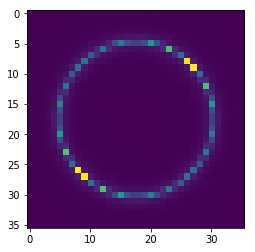

In [47]:
sess = tf.InteractiveSession()

# Host and substructure parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.01, 'theta_y':-0.01, 'theta_E':2.0*0.73}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

# Observational parameters
observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
global_dict = {'z_s':1.0, 'z_l':0.2}

N_lens = 1

lenses_list = [hst_param_dict]
    
# Generate lensed image
LSI = LensingSim(lenses_list, [src_param_dict], global_dict, observation_dict)

i_tot = tf.cast(tf.random.poisson(LSI.lensed_image(),[1])[0], tf.int32)

# i_tot = np.random.poisson(LSI.lensed_image().eval())

# plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims)
# plt.xlabel("$\\theta_x$ [arcsec]");
# plt.ylabel("$\\theta_y$ [arcsec]");
# plt.title('Lensed image');

plt.imshow(np.array(sess.run(i_tot)))

In [60]:
# import edward2 and TensorFlow probability
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed  # edward2 for probability distributions 
import tensorflow as tf

# define our prior parameters
Nmin = 0.5  # lower range of uniform distribution on c
Nmax = 3.5 # upper range of uniform distribution on c

# define our probabilistic model (priors and likelihood)
def log_likelihood(Nmin, Nmax):
    N = ed.Uniform(low=Nmin, high=Nmax, name="N")   # prior on c
    mu=return_Nlens(N)
    Y = ed.Poisson(rate = mu, name="Y")  # likelihood function
    return Y


In [61]:
# convert function to a "joint" function
log_joint = ed.make_log_joint_fn(log_likelihood)

# convert x values and data to tensors
datatensor = tf.convert_to_tensor(i_tot, dtype=tf.int32)
# datatensor = tf.convert_to_tensor(18, dtype=tf.float32)

# function that only takes in the variable parameters
def target_log_prob_fn(N):
    """Target log-probability as a function of states."""
    return log_joint(Nmin, Nmax, N=N, Y=datatensor)  # define y to be our "observed" data


In [62]:
# Keep source parameters fixed for now
LSI = LensingSim(sources_list=[src_param_dict], observation_dict=observation_dict, global_dict=global_dict)

lenses_list = [hst_param_dict]

def return_Nlens(N_lens=2):
    hst_param_dict = {'profile':'sis', 'theta_x':0.01, 'theta_y':-0.01, 'theta_E':N_lens*0.73}
    lenses_list = [hst_param_dict]
    LSI.lenses_list = lenses_list
    return LSI.lensed_image()


In [63]:
# set initial state (drawn from prior)
qN = tf.random_uniform([], minval=Nmin, maxval=Nmax, dtype=tf.float32)

In [ ]:
Nsamples = 5000  # final number of samples
Nburn = 5000     # number of tuning samples

# set up Hamiltonian MC samler kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,step_size=0.1,num_leapfrog_steps=10)                   # the number of steps (sampler steps not MCMC steps)

# create the MCMC sampler
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=Nsamples,     # final number of posterior samples
    current_state=[qN],   # initial state
    kernel=hmc_kernel,        # sampler step method kernel
    num_burnin_steps=Nburn)   # number of burn-in samples

In [74]:
# run the session to extract the samples
with tf.Session() as sess:
    states, is_accepted_ = sess.run([states, kernel_results.is_accepted])  # run the MCMC
    accepted = np.sum(is_accepted_)
    print("Acceptance rate: {}".format(accepted / Nsamples))  # print out acceptance rate

# put posterior chains in a dictionary
results = dict(zip(['N'], states))

# put posterior chains into a numpy array
postsamples = np.vstack((results['N'])).T

KeyboardInterrupt: 

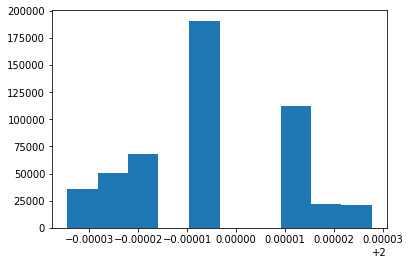

In [69]:
plt.hist(postsamples[0]);

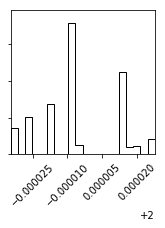

In [70]:
corner.corner(postsamples[0]);